In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

In [2]:
# MSE Imports
import kepler_sieve
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params, elts_add_H
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, MixtureParameters, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel, make_opt_adam
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [3]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [4]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [5]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [6]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [7]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [8]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [9]:
# # Review unperturbed elements
# elts_ast

In [10]:
# Inputs to perturb elements: large
sigma_a = 0.05
sigma_e = 0.01
sigma_inc_deg = 0.25
sigma_f_deg = 1.0
sigma_Omega_deg = 1.0
sigma_omega_deg = 1.0
mask_pert = None
random_seed = 42

# Perturb orbital elements
elts_pert= perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [11]:
# Choose which elements to search on
elts = elts_pert

In [12]:
# # Search for nearest asteroids to these elements
# elts_near = nearest_ast_elt(elts)

In [13]:
# Review selected initial candidate elements, including the nearest asteroid information
# elts

In [14]:
# Review nearest asteroid to these candidate elements
# elts_near

In [15]:
# How many elements are still closest to the original elements?
# np.sum(elts.nearest_ast_num == elts.element_id)

## Batches of ZTF Data Near Initial Candidate Elements

In [16]:
# Arguments to make_ztf_batch
thresh_deg = 2.0
near_ast = False
regenerate = False

In [17]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [18]:
# Review ZTF elements
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
0,306,733,b'ZTF18abiyevm',567274570115015018,3341,58321.274572,275.834958,-12.178240,0.099376,-0.976101,...,0.004095,0.080910,-0.982320,0.168822,2.050675,0.031258,6447.753750,0.999511,0.801975,False
1,6391,733,b'ZTF18ablpbwh',617122522515015016,8730,58371.122523,272.156750,-10.136454,0.037046,-0.972528,...,0.003837,0.016116,-0.975703,0.218503,2.491969,0.024005,4951.468379,0.999712,0.472962,False
2,6392,733,b'ZTF18ablpbwh',618126362515015025,8913,58372.126366,272.156760,-10.136446,0.037046,-0.972528,...,0.003830,0.017464,-0.975564,0.219021,2.503645,0.022568,4655.153797,0.999745,0.418050,False
3,6393,733,b'ZTF18ablpbwh',611146562515015015,7585,58365.146562,272.156733,-10.136444,0.037046,-0.972528,...,0.003876,0.010155,-0.976524,0.215169,2.423439,0.030883,6370.298847,0.999523,0.782824,False
4,12249,733,b'ZTF18ablwzcc',584190354815015015,4647,58338.190359,273.272132,-13.497675,0.055502,-0.983530,...,0.004023,0.030085,-0.980846,0.192450,2.155818,0.032724,6750.065879,0.999465,0.878934,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290766,5650772,324582,b'ZTF20aaqvhnd',1150176700415015000,96618,58904.176701,48.664349,31.318054,0.564235,0.795279,...,-0.001786,0.584015,0.786561,0.200621,2.748814,0.030221,6233.797319,0.999543,0.749638,False
290767,5650773,324582,b'ZTF20aaqvhns',1150176245615015007,96617,58904.176250,45.820577,29.378228,0.607285,0.768505,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.029465,6077.915470,0.999566,0.712618,False
290768,5650789,324582,b'ZTF20aaqvhnm',1150176245015015006,96617,58904.176250,48.881586,28.300138,0.579016,0.797156,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.031743,6547.783696,0.999496,0.827049,False
290769,5650791,324582,b'ZTF20aaqvhog',1150176244815015007,96617,58904.176250,49.429756,29.370649,0.566783,0.802441,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.027275,5625.990260,0.999628,0.610591,False


In [19]:
# Score by element - perturbed
score_by_elt = ztf_score_by_elt(ztf_elt)

In [20]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   290771   (     4543)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :      42.77
Sqrt(batch_obs):      67.40
Mean t_score   :       0.58


In [21]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [22]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, R_deg=R_deg, thresh_deg=thresh_deg)

In [23]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [24]:
# Review perturbed elements; includes nearest asteroid number and distance
elts

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,thresh_s,H,sigma_mag
0,51921,2.736430,0.219134,0.499988,4.721815,2.452489,-1.129754,58600.0,10,0.008727,0.034905,16.5,4.0
1,59244,2.616575,0.266087,0.462848,5.725946,1.777382,-1.623105,58600.0,10,0.008727,0.034905,16.5,4.0
2,15786,1.945213,0.047621,0.385594,6.142435,0.790543,-1.243047,58600.0,10,0.008727,0.034905,16.5,4.0
3,3904,2.758664,0.099270,0.261841,5.463683,2.238942,-1.350620,58600.0,10,0.008727,0.034905,16.5,4.0
4,142999,2.589450,0.192070,0.509382,0.221844,0.928905,-1.314727,58600.0,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.330603,0.084892,0.117649,0.042808,2.890716,-3.000560,58600.0,10,0.008727,0.034905,16.5,4.0
60,134815,2.550916,0.141660,0.510228,0.284591,0.630896,-0.920797,58600.0,10,0.008727,0.034905,16.5,4.0
61,27860,2.595202,0.098315,0.194023,5.535984,3.255585,3.966790,58600.0,10,0.008727,0.034905,16.5,4.0
62,85937,2.216242,0.195323,0.437115,5.285351,3.172956,3.921169,58600.0,10,0.008727,0.034905,16.5,4.0


## Train on Perturbed Elements: Learn Mixture Parameters

In [25]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [26]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0
save_at_end: bool = True

In [35]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model')

In [28]:
# Report before training starts
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec : thresh_deg
Mean :     0.08  :   0.00 :  0.498817 :  1795.74 : 2.000000
Std  :     0.88  :   0.00 :  0.001609 :     5.79 : 0.000000
Min  :    -1.31  :   0.00 :  0.498004 :  1792.82 : 2.000000
Max  :     3.58  :   0.00 :  0.502003 :  1807.21 : 2.000000
Trained for 0 batches over 0 epochs and 0 episodes.


In [37]:
# Train perturbed model with frozen orbital elements
model.freeze_candidate_elements()
model.thaw_score()

In [39]:
model.search_adaptive(
    max_batches=model.current_batch + 1000, 
    learning_rate=2.0**-10,
)

Applying learning_rate 9.77e-04 (2.0^-10.0) for adaptive training.

Training episode 2: Epoch   10, Batch   1000
effective_learning_rate=6.027e-04, training_time 81 sec.
Train on 6400 samples
Epoch 11/15
6400/6400 [==============================] - 4s 670us/sample - loss: -1666975.1575
Epoch 12/15
6400/6400 [==============================] - 3s 419us/sample - loss: -1700162.8150
Epoch 13/15
6400/6400 [==============================] - 3s 417us/sample - loss: -1724052.4250
Epoch 14/15
6400/6400 [==============================] - 3s 401us/sample - loss: -1742249.0350
Epoch 15/15
6400/6400 [==============================] - 3s 417us/sample - loss: -1755003.2075
Adjusted element weight down on 47 candidate elements. Mean weight = 4.34e-01
Geom Mean Resolution: 0.357526 degrees (1287.1 arc seconds)
Mean Hits          :      0.00
Mean Log Likelihood:     10.63

Training episode 3: Epoch   15, Batch   1500
effective_learning_rate=4.234e-04, training_time 101 sec.
Train on 6400 samples
Epoch 1

In [31]:
# model.save_state()

In [32]:
# # Load model
# model.load()

In [40]:
# Report results
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec : thresh_deg
Mean :    10.63  :   0.00 :  0.430011 :  1548.04 : 2.000000
Std  :    21.75  :   0.00 :  0.232160 :   835.78 : 0.000000
Min  :    -0.99  :   0.00 :  0.058645 :   211.12 : 2.000000
Max  :   103.56  :   0.00 :  0.999962 :  3599.86 : 2.000000
Trained for 2000 batches over 20 epochs and 4 episodes.


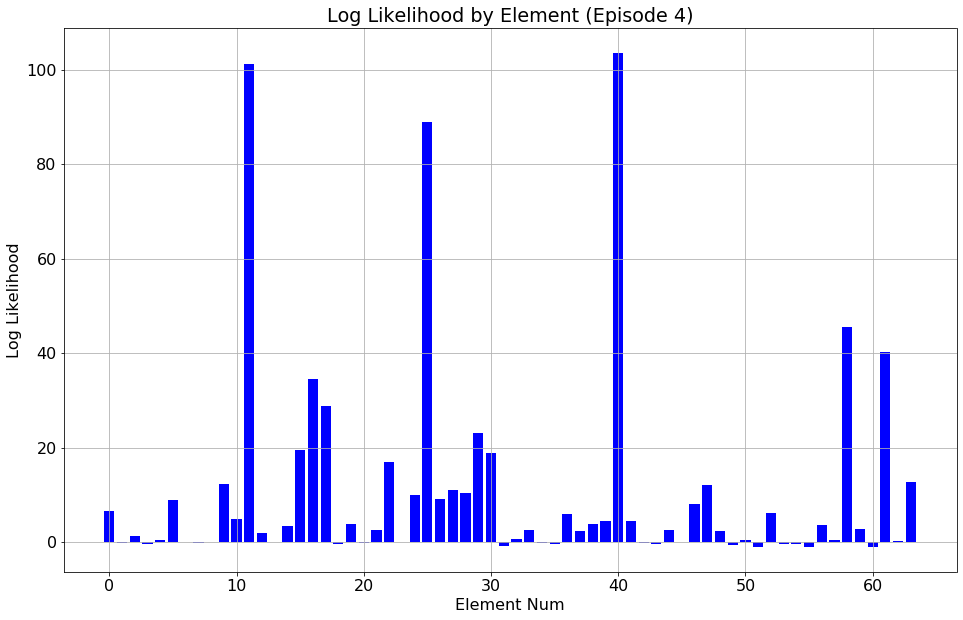

In [41]:
# Visualize log likelihood before traning
fig, ax = model.plot_bar('log_like', sorted=False)

## Train on Perturbed Model: Joint (Elements & Mixture)

In [42]:
# Adaptive search parameters
batches_per_epoch = 100
epochs_per_episode = 5
max_bad_episodes = 3
min_learning_rate = None
save_at_end = False
reset_active_weight = True
verbose = 1

In [44]:
# Unfreeze the elements
model.thaw_candidate_elements()
model.thaw_mixture_parameters()
model.thaw_score()

In [45]:
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec : thresh_deg
Mean :    10.63  :   0.00 :  0.430011 :  1548.04 : 2.000000
Std  :    21.75  :   0.00 :  0.232160 :   835.78 : 0.000000
Min  :    -0.99  :   0.00 :  0.058645 :   211.12 : 2.000000
Max  :   103.56  :   0.00 :  0.999962 :  3599.86 : 2.000000
Trained for 2000 batches over 20 epochs and 4 episodes.


In [46]:
# model.save_state()

In [ ]:
# model.set_thresh_deg_max(1.0)

In [ ]:
# Train model on mixture parameters only
model.freeze_candidate_elements()
model.search_adaptive(
    max_batches=model.current_batch+1000,
    learning_rate=2.0**-10,
    reset_active_weight=True)

In [50]:
# Train model in joint mode
model.thaw_candidate_elements()
model.search_adaptive(
    max_batches=model.current_batch+2000,
    learning_rate=2.0**-12,
    reset_active_weight=True)


Training episode 10: Epoch   43, Batch   4300
effective_learning_rate=2.441e-04, training_time 259 sec.
Train on 6400 samples
Epoch 44/48
6400/6400 [==============================] - 5s 827us/sample - loss: -3991272.6200
Epoch 45/48
6400/6400 [==============================] - 3s 529us/sample - loss: -3177788.2600
Adjusted element weight down on 49 candidate elements. Mean weight = 6.17e-01
Geom Mean Resolution: 0.161603 degrees ( 581.8 arc seconds)
Mean Hits          :     25.55
Mean Log Likelihood:    160.82

Training episode 11: Epoch   45, Batch   4500
effective_learning_rate=1.507e-04, training_time 295 sec.
Train on 6400 samples
Epoch 46/50
6400/6400 [==============================] - 3s 540us/sample - loss: -3268729.8075
Epoch 47/50
6400/6400 [==============================] - 3s 542us/sample - loss: -3240369.1400
Adjusted element weight down on 49 candidate elements. Mean weight = 4.14e-01
Geom Mean Resolution: 0.163291 degrees ( 587.8 arc seconds)
Mean Hits          :     25.

In [51]:
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec : thresh_deg
Mean :   164.10  :  25.64 :  0.298410 :  1074.28 : 1.714000
Std  :   163.81  :  57.68 :  0.251555 :   905.60 : 0.565855
Min  :     8.05  :   0.00 :  0.016030 :    57.71 : 0.132818
Max  :   648.18  : 189.51 :  0.999962 :  3599.86 : 2.000000
Trained for 6300 batches over 63 epochs and 17 episodes.


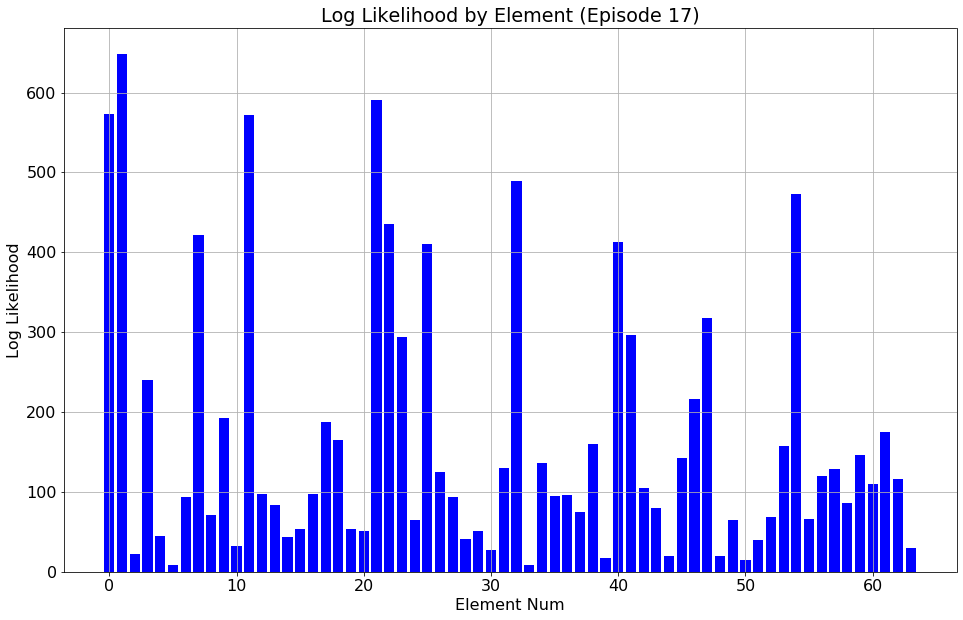

In [52]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

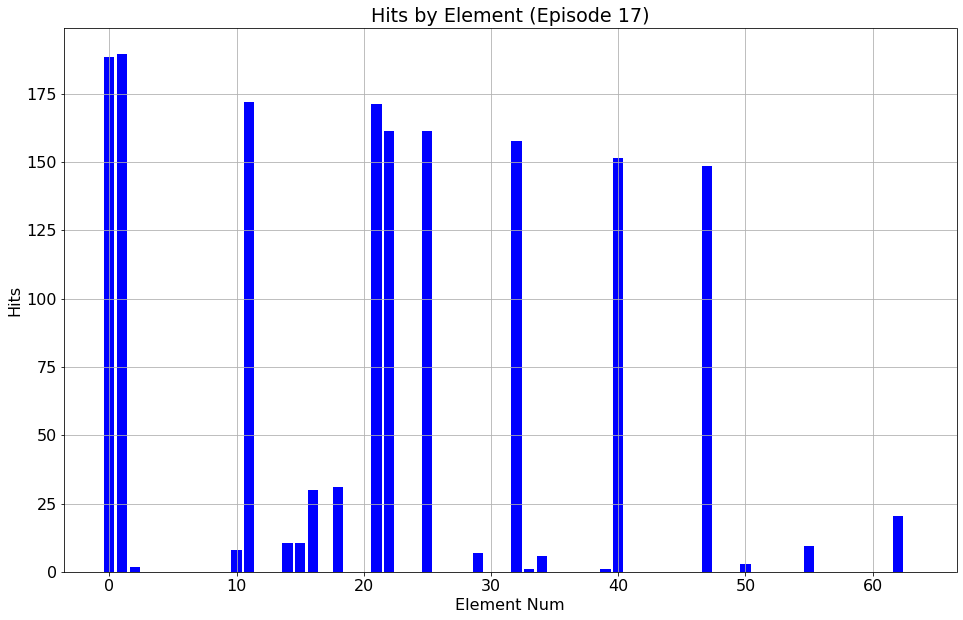

In [53]:
# Bar chart - hits
fig, ax = model.plot_bar('hits', sorted=False)

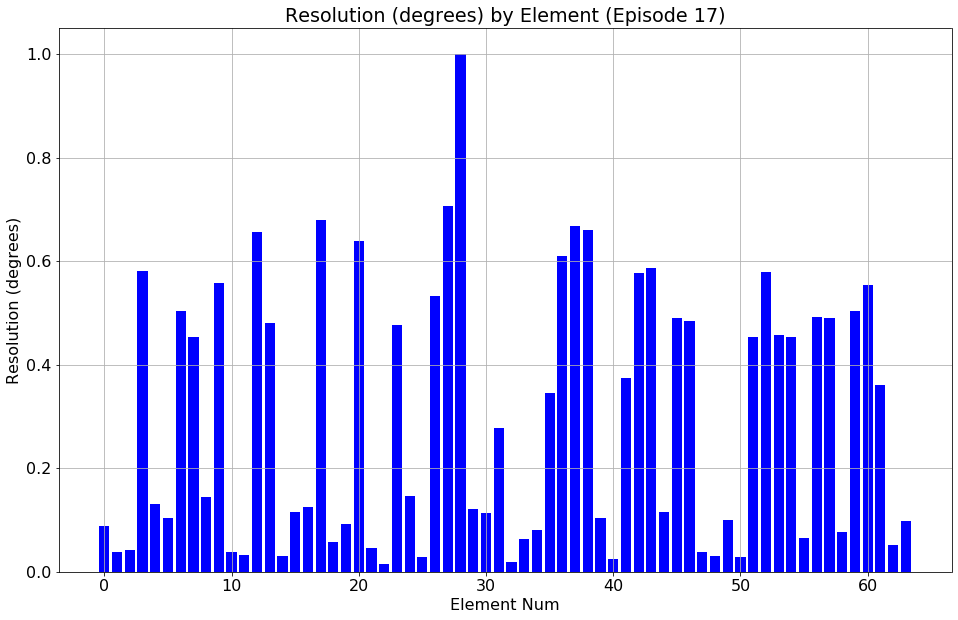

In [56]:
# Bar chart - resolution
fig, ax = model.plot_bar('R_deg', sorted=False)

In [ ]:
# Bar chart - sigma_mag
fig, ax = model.plot_bar('sigma_mag', sorted=False)

In [ ]:
# # Save model
# model.save_state()

In [ ]:
# Search with frozen elements
model.freeze_candidate_elements()
model.search_adaptive(
    max_batches=model.current_batch+1000, 
    learning_rate=2**-10,
    reset_active_weight=True)

In [ ]:
model.report()

In [ ]:
fig, ax = model.plot_bar('log_like', sorted=False)

In [ ]:
# model.save_state()

In [ ]:
# Search with live elements
model.thaw_candidate_elements()
model.search_adaptive(
    max_batches=model.current_batch+5000,
    learning_rate=2**-15,
    reset_active_weight=True)

In [ ]:
model.report()

In [ ]:
fig, ax = model.plot_bar('log_like', sorted=False)

In [ ]:
# model.save_state()

In [ ]:
# # Unfreeze the score layer
# model.thaw_score()

In [ ]:
# Length of training
max_batches_element = 22000

# thresh_deg at end: 500 arc seconds
thresh_deg_end = 500 / 3600.0

# New smaller learning rate
learning_rate = 2.0**-15

# Reset active weight
reset_active_weight = True

In [ ]:
# Train model in joint mode
model.search_adaptive(
    max_batches=max_batches_element, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    thresh_deg_end=thresh_deg_end,
    learning_rate=learning_rate,
    reset_active_weight=reset_active_weight,
    verbose=verbose)

In [ ]:
model.report()

In [ ]:
# model.save_state()

In [ ]:
# Lower threshold manually
thresh_deg_score = 1.0
model.set_thresh_deg_max(thresh_deg_score)
model.freeze_score()

In [ ]:
model.search_adaptive(
    max_batches=20000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    learning_rate=2.0**-15,
    reset_active_weight=True,
    verbose=verbose)

In [ ]:
model.report()

In [ ]:
# model.save_state()

## Review Results Graphically

In [ ]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

In [ ]:
# Bar chart: hits
fig, ax = model.plot_bar('hits', sorted=False)

In [ ]:
# Bar chart: log likelihood
fig, ax = model.plot_bar('log_R', sorted=False)

In [ ]:
# # Learning curve: log likelihood
# fig, ax = model.plot_hist('log_like')

In [ ]:
# # Learning curve: hits
# fig, ax = model.plot_hist('hits')

## Distance vs. Nearest Asteroid for Fitted Elements

In [57]:
# Find nearest asteroid to fitted elements
elts_fit, elts_near = model.nearest_ast()

In [ ]:
q_norm = elt_q_norm(elts=elts_fit, ast_num=elts_fit.nearest_ast_num)
elts_fit['nearest_ast_q_norm'] = q_norm

In [58]:
# Review asteroids nearest to the fitted elements
elts_near

,element_id,nearest_ast_num,nearest_ast_name,nearest_ast_dist,a,e,inc,Omega,omega,f,epoch
0,51921,252633,2001 XQ213,0.011108,2.754397,0.238638,0.277118,4.545567,2.430909,-1.067569,58600.0
1,59244,59244,1999 CG6,0.000441,2.634727,0.262503,0.465045,5.738298,1.766995,-1.601363,58600.0
2,15786,425432,2010 DH49,0.004026,1.914492,0.049429,0.316276,6.125888,2.421193,-2.829302,58600.0
3,3904,103630,2000 CS29,0.005352,2.998253,0.117762,0.161411,5.610181,1.833938,-0.929535,58600.0
4,142999,451765,2013 FU21,0.011941,2.534545,0.080992,0.267551,0.255508,1.160176,-1.460808,58600.0
...,...,...,...,...,...,...,...,...,...,...,...
59,11952,1136861,2014 DR146,0.003023,2.271782,0.078945,0.058293,0.274897,2.598040,-3.020411,58600.0
60,134815,189733,2001 XU2,0.010332,2.386655,0.162962,0.401402,0.281197,1.597802,-2.130746,58600.0
61,27860,253900,2004 BB112,0.004276,2.579632,0.110737,0.142087,5.440873,2.979604,-2.044633,58600.0
62,85937,440988,2007 DJ6,0.009928,2.264674,0.232179,0.422332,5.781728,2.839216,-2.613202,58600.0


In [59]:
# Review fitted elements including nearest asteroid
elts_fit

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_s,thresh_deg,thresh_sec,log_like,hits,H,sigma_mag,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
0,51921,2.743712,0.231926,0.504941,4.695816,2.480023,-1.142756,58600.0,276.404694,0.001558,...,0.023008,1.318317,4745.940918,572.777344,188.274811,14.171280,0.930176,252633,0.011108,2.284216
1,59244,2.636086,0.263898,0.464954,5.737883,1.777438,-1.609002,58600.0,198.787079,0.000662,...,0.008199,0.469748,1691.091797,648.183228,189.512680,16.137625,0.500000,59244,0.000441,0.091968
2,15786,1.915370,0.043991,0.378982,6.131669,0.779352,-1.246183,58600.0,25.408054,0.000747,...,0.034905,2.000000,7199.998535,22.751406,1.908830,17.120308,0.767529,425432,0.004026,2.437207
3,3904,2.992792,0.141973,0.252439,5.555412,2.197702,-1.339931,58600.0,785.114990,0.010139,...,0.034905,2.000000,7199.998535,239.588181,0.000000,15.694473,1.415529,103630,0.005352,1.281554
4,142999,2.526700,0.191814,0.503373,0.219027,0.873269,-1.293653,58600.0,98.352470,0.002281,...,0.034905,2.000000,7199.998535,45.123035,0.000000,17.900305,2.647472,451765,0.011941,2.391899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.264415,0.071030,0.122689,0.057213,2.837668,-3.023724,58600.0,696.943787,0.008792,...,0.034905,2.000000,7199.998535,146.821106,0.000000,19.554186,2.522292,1136861,0.003023,1.141251
60,134815,2.391112,0.104738,0.508515,0.260907,0.618665,-0.929189,58600.0,432.962036,0.009668,...,0.034905,2.000000,7199.998535,110.039207,0.000000,16.601013,3.043170,189733,0.010332,2.615046
61,27860,2.568217,0.103308,0.192483,5.469029,3.285360,3.979409,58600.0,498.830292,0.006294,...,0.034905,2.000000,7199.998535,175.367737,0.000000,20.950144,4.153786,253900,0.004276,0.684711
62,85937,2.258401,0.170951,0.463830,5.278295,3.204425,3.914300,58600.0,43.511044,0.000915,...,0.021275,1.218982,4388.336914,115.626167,20.254139,13.746981,1.626196,440988,0.009928,1.370855


In [61]:
# Filter for only the good ones
mask = (elts_fit.log_like > 200) & (elts_fit.R_sec < 120)
elts_fit[mask]

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_s,thresh_deg,thresh_sec,log_like,hits,H,sigma_mag,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
11,9936,3.068843,0.183062,0.268870,5.417297,0.233125,0.735438,58600.0,176.723907,0.000557,...,0.005569,0.319094,1148.737061,571.341797,171.961029,13.536049,0.548134,9936,0.002037,0.045809
22,9229,2.908422,0.069753,0.018568,4.881742,2.921966,-1.044649,58600.0,161.113007,0.000280,...,0.002318,0.132818,478.145477,435.136597,161.406693,13.326957,1.864544,9229,0.000117,0.017061
25,203722,3.175813,0.292435,0.426149,5.309231,1.792438,-1.164701,58600.0,164.090134,0.000508,...,0.004959,0.284119,1022.828857,410.184235,161.181107,16.432053,0.507793,203722,0.000761,0.013977
32,19794,2.428303,0.081035,0.210846,0.421370,1.439313,-1.857138,58600.0,131.640396,0.000331,...,0.006529,0.374076,1346.671875,489.872864,157.743408,14.367170,1.028040,19794,0.000181,0.050928
40,31539,3.216692,0.178609,0.297378,5.773678,5.037836,1.790367,58600.0,159.600571,0.000441,...,0.005577,0.319566,1150.438110,412.938354,151.565475,13.465404,0.537890,31539,0.000517,0.023122


In [66]:
ast_elt.loc[9229:9229]

,Num,Name,epoch,a,e,inc,Omega,omega,M,H,G,Ref,f,P,n,long,theta,pomega,T_peri,row_num
Num,,,,,,,,,,,,,,,,,,,,
9229,9229,Matsuda,58600.0,2.907894,0.069616,0.018449,4.883385,2.915996,5.359359,13.5,0.15,JPL 27,-1.040787,1811.199102,0.003469,0.59237,0.475409,1.516196,266.303227,9222


In [ ]:
# Filter for incomplete convergence
mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

In [ ]:
model.elts_near_ast

In [ ]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(is_log=True, use_near_ast_dist=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elt_name='a', is_log=True, elt_num=None)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elt_name='e', is_log=True, elt_num=None)